# Brownian Motion as a classification problem

Create simulation

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import torch
from pygsig.graph import StaticGraphTemporalSignal

class Simulation():
    def __init__( self,
                 num_nodes,
                 num_blocks, 
                 p_across_blocks,
                 p_within_blocks,
                 mu_gain,beta_gain,
                 sigma_gain,
                 omega_noise,
                 time_horizon,
                 task='classification',
                 dt = 1e-3):
        
        self.num_nodes = num_nodes
        self.num_blocks = num_blocks
        self.p_across_blocks = p_across_blocks
        self.p_within_blocks = p_within_blocks
        self.mu_gain = mu_gain
        self.beta_gain = beta_gain
        self.sigma_gain = sigma_gain
        self.omega_noise = omega_noise
        self.time_horizon = time_horizon
        self.dt = dt
        self.num_time_steps = int(time_horizon / dt)
        self.task = task

    def run(self,graph_seed,omega_seed,param_seed):

        # synchronization
        def kuramoto(graph, theta, omega, dt):
            dtheta = omega * dt  # Initialize with intrinsic frequencies
            for u, v, data in graph.edges(data=True):
                coupling = data['weight']
                dtheta[u] += dt * coupling * np.sin(theta[v] - theta[u])
                dtheta[v] += dt * coupling * np.sin(theta[u] - theta[v])
            return theta + dtheta

        # drift of the SDE
        def periodic_drift(beta, theta, omega, mu_0, t):
            return mu_0 + beta*np.sin(omega*t + theta)

        # Create a graph
        block_sizes = [self.num_nodes // self.num_blocks] * self.num_blocks
        block_probs = np.zeros((self.num_blocks, self.num_blocks))

        for i in range(self.num_blocks):
            for j in range(self.num_blocks):
                if i == j:
                    block_probs[i, j] = self.p_within_blocks
                else:
                    block_probs[i, j] = self.p_across_blocks
        
        graph = nx.stochastic_block_model(block_sizes, block_probs, seed=graph_seed)

        for edge in graph.edges:
            if graph.nodes[edge[0]]['block'] == graph.nodes[edge[1]]['block']:
                graph[edge[0]][edge[1]]['weight'] = 1/(np.sqrt(graph.degree[edge[0]]*graph.degree[edge[1]]))
            else:
                graph[edge[0]][edge[1]]['weight'] = 1/(np.sqrt(graph.degree[edge[0]]*graph.degree[edge[1]]))
        
        # Assign omega to each node
        np.random.seed(omega_seed)
        omega_range = np.linspace(0,1, self.num_blocks+1)[1:]
        for node in graph.nodes:
            graph.nodes[node]['omega'] = omega_range[graph.nodes[node]['block']] + self.omega_noise * np.random.randn()
        
        # Othe oscilator perameters
        np.random.seed(param_seed)
        omega = np.array([graph.nodes[node]['omega'] for node in graph.nodes])
        block = np.array([graph.nodes[node]['block'] for node in graph.nodes])
        beta =  self.beta_gain * np.random.rand(self.num_nodes) # amplitude (uniform nodes)
        theta = 2 * np.pi * np.random.rand(self.num_nodes)  # initial phase (random across nodes)
        mu_0 = self.mu_gain * np.random.rand(self.num_nodes)

        # initial values
        X = np.random.rand(self.num_nodes) # signal

        # Simulate
        theta_traj = np.zeros((self.num_nodes,self.num_time_steps))
        mu_traj = np.zeros((self.num_nodes,self.num_time_steps))
        X_traj = np.zeros((self.num_nodes,self.num_time_steps))

        # Time sequence
        tt = np.arange(0, self.time_horizon, self.dt)
        for step,t in enumerate(tt):
            theta_traj[:, step] = theta
            if step == 0:
                mu_traj[:,step] = mu_0
            else:
                mu_traj[:,step] = mu
            X_traj[:,step] = X
            theta = kuramoto(graph, theta, omega,self.dt)
            mu = periodic_drift(beta, theta,omega, mu_0, t)
            X = X + self.dt * mu + np.sqrt(self.dt) * self.sigma_gain*np.random.randn(self.num_nodes)
        
        self.X = X_traj
        self.theta = theta_traj
        self.mu = mu_traj
        self.block = block
        self.omega = omega
        self.mu_0 = mu_0
        self.beta = beta
        self.graph = graph
    
    def get_sequence(self):
        from sklearn.preprocessing import OneHotEncoder
        one_hot = OneHotEncoder()

        if self.task == 'classification':
            y = one_hot.fit_transform(self.block.reshape(-1,1)).toarray()
        if self.task == 'regression':
            y = self.omega.reshape(-1,1)

        snapshot_count = self.X.shape[1]
        df_edge = nx.to_pandas_edgelist(self.graph.to_directed())
        edge_index = torch.tensor(df_edge[['source','target']].values.T,dtype=torch.long)
        edge_weight = torch.tensor(df_edge['weight'].values,dtype=torch.float)
        snapshot_count = self.X.shape[1]
        features = [ torch.tensor(self.X[:,t],dtype=torch.float).unsqueeze(-1) for t in range(snapshot_count)]
        targets = [ y for _ in range(snapshot_count)]
        # Sequential Data
        return StaticGraphTemporalSignal(edge_index=edge_index,edge_weight=edge_weight,features=features,targets=targets)


Make dataset consisting of multiple SDE trajectories

In [71]:
from tqdm import tqdm

simulation =   Simulation(num_nodes= 300,
            num_blocks=3,
            p_across_blocks=0.05,
            p_within_blocks=0.1,
            mu_gain= 1,
            beta_gain=4,
            sigma_gain=1.0,
            omega_noise=0.2,
            time_horizon=10,
            task='classification',
            dt=1e-1)

base_seed = 0
seq_dataset = []
num_runs = 10

with tqdm(total=num_runs) as pbar:
    for run in range(num_runs):
        simulation.run(graph_seed=run,omega_seed=run,param_seed=run)
        seq = simulation.get_sequence()
        seq_dataset.append(seq)
        pbar.update(1)

100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


save/load dataset

In [ ]:
import torch

filename = 'datasets/brownian/1d-3b-class-noisy-LF-hetero.pt'
torch.save(seq_dataset,filename)
# seq_dataset = torch.load(filename)

Train, baby, train!

Signature depth: 4


100%|██████████| 10/10 [00:00<00:00, 33.26it/s]


Name: GCNClassification
Number of parameters: 2179
Number of layers: 2
Signature depth: 4
Splits: 5, Trials: 4, Runs: 10, Epochs: 800


100%|██████████| 200/200 [09:20<00:00,  2.80s/it]

Accuracy: 0.5626 ± 0.0620, Recall: 0.5626 ± 0.0620, Precision: 0.5626 ± 0.0620, F1: 0.5626 ± 0.0620


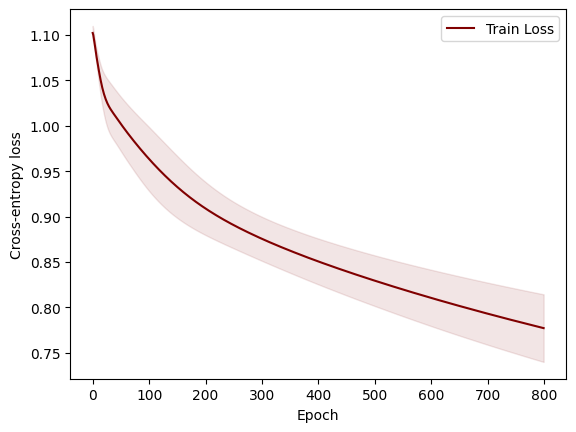

In [73]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from signatory import signature_channels
from pygsig.signature import SignatureFeatures


import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GCNClassification,MLPClassification
from pygsig.graph import  split_nodes

import importlib
importlib.reload(pygsig.models)
importlib.reload(pygsig.signature)
importlib.reload(pygsig.graph)

num_nodes = seq_dataset[0].num_nodes
dim = 1
out_channels = seq_dataset[0].y.shape[1]
num_splits = 5 # split the nodes
num_runs = len(seq_dataset)
num_trials = 4
num_epochs = 800

# hyperparameters
learning_rate = 1e-3
lasso = 0
num_hidden = 64

print_during_training = False

all_models = []
all_model_parameters = []
all_model_depths = []
all_model_layers = []
all_models_accuracy = []
all_models_recall = []
all_models_precision = []
all_models_f1 = []
all_models_confusion = []

# create models 
min_depth = 4
max_depth = 4
min_hidden_layers = 1
max_hidden_layers = 1

for depth in range(min_depth,max_depth+1):
    print(f'Signature depth: {depth}')
    dataset = []
    for seq in tqdm(seq_dataset):
        signature_transform = SignatureFeatures(sig_depth=depth, normalize=True, log_signature=False,lead_lag=True)
        dataset.append(signature_transform(seq))

    for num_layers in range(min_hidden_layers,max_hidden_layers+1):
        in_channels = signature_channels(2*dim,depth)
        model = GCNClassification(num_channels=[in_channels]+num_layers*[num_hidden]+[out_channels])
        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f'Name: {model._get_name()}')
        print(f"Number of parameters: {num_params}")
        print(f"Number of layers: {num_layers+1}")
        print(f"Signature depth: {depth}")
        print(f"Splits: {num_splits}, Trials: {num_trials}, Runs: {num_runs}, Epochs: {num_epochs}")
        all_model_parameters.append(num_params)
        all_model_layers.append(num_layers+1)
        all_model_depths.append(depth)
        
        criterion = nn.CrossEntropyLoss()

        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=lasso) 
        train_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs]) 
        eval_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs])
        accuracy = np.zeros([num_splits, num_runs, num_trials])
        recall = np.zeros([num_splits, num_runs, num_trials])
        precision = np.zeros([num_splits, num_runs, num_trials])
        f1 = np.zeros([num_splits, num_runs, num_trials])
        confusion = np.zeros([num_splits, num_runs, num_trials,out_channels,out_channels])

        with tqdm(total=num_splits*num_runs*num_trials, disable=print_during_training) as pbar:
            splits = split_nodes(num_nodes, num_splits,test_ratio=1.0,seed=29)
            for split in range(num_splits):
                train_indices, eval_indices, test_indices = splits[split]
                train_mask = torch.zeros(num_nodes, dtype=torch.bool)
                eval_mask = torch.zeros(num_nodes, dtype=torch.bool)
                test_mask = torch.zeros(num_nodes, dtype=torch.bool)
                train_mask[train_indices] = True
                eval_mask[eval_indices] = True
                test_mask[test_indices] = True
                for run, data in enumerate(dataset):
                    for trial in range(num_trials):
                        model.reset_parameters()
                        for epoch in range(num_epochs):
                            # train
                            model.train()
                            optimizer.zero_grad()
                            out = model(data.x, data.edge_index)
                            train_loss = criterion(out[train_mask], data.y[train_mask])
                            train_loss.backward()
                            optimizer.step()
                            # evaluate
                            model.eval()
                            with torch.no_grad():
                                eval_loss = criterion(out[eval_mask], data.y[eval_mask])
                                train_losses[split, run, trial, epoch] = train_loss.item()
                                eval_losses[split, run, trial, epoch] = eval_loss.item()
                            if epoch % 10 == 0 and print_during_training:
                                print(f'Split {split}, Run {run}, Trial {trial}, Epoch {epoch}, Train Loss: {train_loss.item():.4f}')
                        pbar.update(1)
                        # compute the errors on the testing loss after the last epoch
                        with torch.no_grad():
                            out = model(data.x, data.edge_index)
                            accuracy[split,run,trial] = accuracy_score(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy())
                            recall[split,run,trial] = recall_score(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy(),average='micro')
                            precision[split,run,trial] = precision_score(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy(),average='micro')
                            f1[split,run,trial] = f1_score(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy(),average='micro')
                            confusion[split,run,trial] = confusion_matrix(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy())
        print(f'Accuracy: {np.mean(accuracy):.4f} ± {np.std(accuracy):.4f}, Recall: {np.mean(recall):.4f} ± {np.std(recall):.4f}, Precision: {np.mean(precision):.4f} ± {np.std(precision):.4f}, F1: {np.mean(f1):.4f} ± {np.std(f1):.4f}')
        all_models_accuracy.append(accuracy)
        all_models_recall.append(recall)
        all_models_precision.append(precision)
        all_models_f1.append(f1)
        all_models_confusion.append(confusion)

        # Plotting
        avg_train_losses = np.mean(train_losses, axis=(0,1,2))
        std_train_losses = np.std(train_losses, axis=(0,1,2))
        
        plt.figure()
        plt.plot(avg_train_losses,  label='Train Loss', color='maroon')
        plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
        plt.xlabel('Epoch')
        plt.ylabel('Cross-entropy loss')
        plt.legend()
        plt.show()

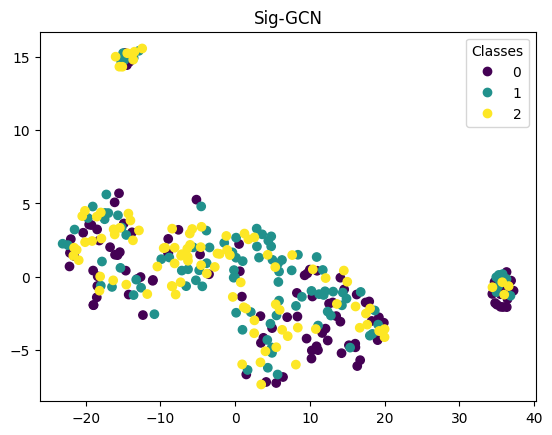

In [74]:
from sklearn.manifold import TSNE

latent_variables = model.conv[0](data.x,data.edge_index)

tsne = TSNE(n_components=2,perplexity=30,random_state=30)
X_embedded = tsne.fit_transform(latent_variables.detach().numpy())

plt.figure()
scatter = plt.scatter(X_embedded[:,0],X_embedded[:,1],c=data.y.argmax(dim=1).numpy())
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title('Sig-GCN')
plt.show()

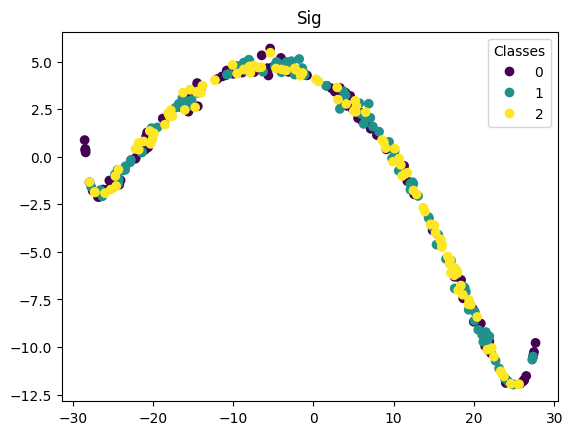

In [75]:
tsne = TSNE(n_components=2,perplexity=30,random_state=30)
X_embedded = tsne.fit_transform(data.x.detach().numpy())

plt.figure()
scatter = plt.scatter(X_embedded[:,0],X_embedded[:,1],c=data.y.argmax(dim=1).numpy())
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title('Sig')
plt.show()

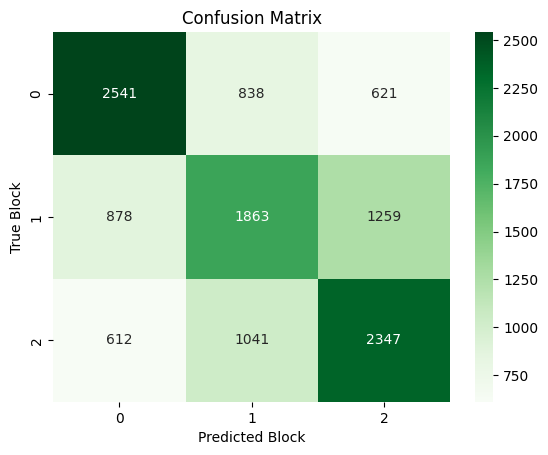

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

mean_cm = [cm.sum(axis=(0,1,2)) for cm in all_models_confusion]
for cm in mean_cm:
    plt.figure()
    plt.title('Confusion Matrix')
    sns.heatmap(cm, annot=True, fmt='g', cmap='Greens')
    plt.xlabel('Predicted Block')
    plt.ylabel('True Block')
    plt.show()

Dataframe with all results

In [10]:
import pandas as pd
import numpy as np

# Collecting data in a list of dictionaries
data = []
# Populate the data list
for idx in range(len(all_models_accuracy)):
    for split in range(all_models_accuracy[0].shape[0]):
        for run in range(all_models_accuracy[0].shape[1]):
            for trial in range(all_models_accuracy[0].shape[2]):
                # Extract MAE and RMSE for the current model, split, and run
                accuracy_value = all_models_accuracy[idx][split, run, trial]
                precision_value = all_models_precision[idx][split, run, trial]
                recall_value = all_models_recall[idx][split, run, trial]
                f1_value = all_models_f1[idx][split, run, trial]
                num_layers = all_model_layers[idx]
                depth = all_model_depths[idx]
                num_params = all_model_parameters[idx]
                
                # Append the data as a dictionary
                data.append({
                    'SigDepth': depth,
                    'NumLayers': num_layers,
                    'NumParams': num_params,
                    'Split': split,
                    'Run': run,
                    'Trial': trial,
                    'Accuracy': accuracy_value,
                })

# Create the DataFrame from the list of dictionaries
df = pd.DataFrame(data)
df.to_json('results/brownian_gcn_1d_3b_class.json')

### MLP

Signature depth: 4


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 36.15it/s]


Name: MLPClassification
Number of parameters: 10499
Number of layers: 4
Signature depth: 4
Splits: 5, Trials: 4, Runs: 10, Epochs: 200


100%|██████████| 200/200 [00:24<00:00,  8.03it/s]

Accuracy: 0.3885 ± 0.0792, Recall: 0.3885 ± 0.0792, Precision: 0.3885 ± 0.0792, F1: 0.3885 ± 0.0792


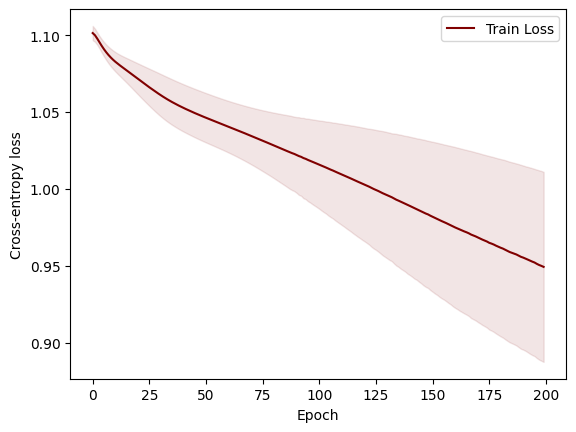

In [77]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from signatory import signature_channels
from pygsig.signature import SignatureFeatures


import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GCNClassification,MLPClassification
from pygsig.graph import  split_nodes

import importlib
importlib.reload(pygsig.models)
importlib.reload(pygsig.signature)
importlib.reload(pygsig.graph)

num_nodes = seq_dataset[0].num_nodes
dim = 1
out_channels = seq_dataset[0].y.shape[1]
num_splits = 5 # split the nodes
num_runs = len(seq_dataset)
num_trials = 4
num_epochs = 200

# hyperparameters
learning_rate = 1e-3
lasso = 0
num_hidden = 64

print_during_training = False

all_models = []
all_model_parameters = []
all_model_depths = []
all_model_layers = []
all_models_accuracy = []
all_models_recall = []
all_models_precision = []
all_models_f1 = []
all_models_confusion = []

# create models 
min_depth = 4
max_depth = 4
min_hidden_layers = 3
max_hidden_layers = 3

for depth in range(min_depth,max_depth+1):
    print(f'Signature depth: {depth}')
    dataset = []
    for seq in tqdm(seq_dataset):
        signature_transform = SignatureFeatures(sig_depth=depth, normalize=True, log_signature=False,lead_lag=True)
        dataset.append(signature_transform(seq))

    for num_layers in range(min_hidden_layers,max_hidden_layers+1):
        in_channels = signature_channels(2*dim,depth)
        model = MLPClassification(num_channels=[in_channels]+num_layers*[num_hidden]+[out_channels])
        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f'Name: {model._get_name()}')
        print(f"Number of parameters: {num_params}")
        print(f"Number of layers: {num_layers+1}")
        print(f"Signature depth: {depth}")
        print(f"Splits: {num_splits}, Trials: {num_trials}, Runs: {num_runs}, Epochs: {num_epochs}")
        all_model_parameters.append(num_params)
        all_model_layers.append(num_layers+1)
        all_model_depths.append(depth)
        
        criterion = nn.CrossEntropyLoss()

        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=lasso) 
        train_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs]) 
        eval_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs])
        accuracy = np.zeros([num_splits, num_runs, num_trials])
        recall = np.zeros([num_splits, num_runs, num_trials])
        precision = np.zeros([num_splits, num_runs, num_trials])
        f1 = np.zeros([num_splits, num_runs, num_trials])
        confusion = np.zeros([num_splits, num_runs, num_trials,out_channels,out_channels])

        with tqdm(total=num_splits*num_runs*num_trials, disable=print_during_training) as pbar:
            splits = split_nodes(num_nodes, num_splits,test_ratio=1.0,seed=29)
            for split in range(num_splits):
                train_indices, eval_indices, test_indices = splits[split]
                train_mask = torch.zeros(num_nodes, dtype=torch.bool)
                eval_mask = torch.zeros(num_nodes, dtype=torch.bool)
                test_mask = torch.zeros(num_nodes, dtype=torch.bool)
                train_mask[train_indices] = True
                eval_mask[eval_indices] = True
                test_mask[test_indices] = True
                for run, data in enumerate(dataset):
                    for trial in range(num_trials):
                        model.reset_parameters()
                        for epoch in range(num_epochs):
                            # train
                            model.train()
                            optimizer.zero_grad()
                            out = model(data.x, data.edge_index)
                            train_loss = criterion(out[train_mask], data.y[train_mask])
                            train_loss.backward()
                            optimizer.step()
                            # evaluate
                            model.eval()
                            with torch.no_grad():
                                eval_loss = criterion(out[eval_mask], data.y[eval_mask])
                                train_losses[split, run, trial, epoch] = train_loss.item()
                                eval_losses[split, run, trial, epoch] = eval_loss.item()
                            if epoch % 10 == 0 and print_during_training:
                                print(f'Split {split}, Run {run}, Trial {trial}, Epoch {epoch}, Train MSE Loss: {train_loss.item():.4f}, Evaulation MSE Loss: {eval_loss.item():.4f}')
                        pbar.update(1)
                        # compute the errors on the testing loss after the last epoch
                        with torch.no_grad():
                            out = model(data.x, data.edge_index)
                            accuracy[split,run,trial] = accuracy_score(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy())
                            recall[split,run,trial] = recall_score(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy(),average='micro')
                            precision[split,run,trial] = precision_score(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy(),average='micro')
                            f1[split,run,trial] = f1_score(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy(),average='micro')
                            confusion[split,run,trial] = confusion_matrix(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy())

        print(f'Accuracy: {np.mean(accuracy):.4f} ± {np.std(accuracy):.4f}, Recall: {np.mean(recall):.4f} ± {np.std(recall):.4f}, Precision: {np.mean(precision):.4f} ± {np.std(precision):.4f}, F1: {np.mean(f1):.4f} ± {np.std(f1):.4f}')
        all_models_accuracy.append(accuracy)
        all_models_recall.append(recall)
        all_models_precision.append(precision)
        all_models_f1.append(f1)
        all_models_confusion.append(confusion)
        all_models.append(model)

        # Plotting
        avg_train_losses = np.mean(train_losses, axis=(0,1,2))
        std_train_losses = np.std(train_losses, axis=(0,1,2))
        
        plt.figure()
        plt.plot(avg_train_losses,  label='Train Loss', color='maroon')
        plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
        plt.xlabel('Epoch')
        plt.ylabel('Cross-entropy loss')
        plt.legend()
        plt.show()

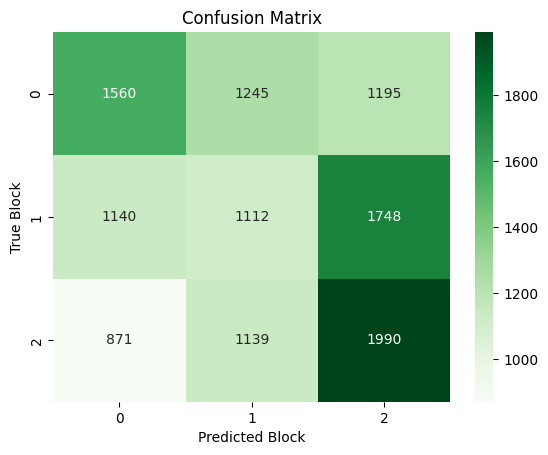

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

mean_cm = [cm.sum(axis=(0,1,2)) for cm in all_models_confusion]
for cm in mean_cm:
    plt.figure()
    plt.title('Confusion Matrix')
    sns.heatmap(cm, annot=True, fmt='g', cmap='Greens')
    plt.xlabel('Predicted Block')
    plt.ylabel('True Block')
    plt.show()

Dataframe with all results

In [41]:
import pandas as pd
import numpy as np

# Collecting data in a list of dictionaries
data = []
# Populate the data list
for idx in range(len(all_models_accuracy)):
    for split in range(all_models_accuracy[0].shape[0]):
        for run in range(all_models_accuracy[0].shape[1]):
            for trial in range(all_models_accuracy[0].shape[2]):
                # Extract MAE and RMSE for the current model, split, and run
                accuracy_value = all_models_accuracy[idx][split, run, trial]
                precision_value = all_models_precision[idx][split, run, trial]
                recall_value = all_models_recall[idx][split, run, trial]
                f1_value = all_models_f1[idx][split, run, trial]
                num_layers = all_model_layers[idx]
                depth = all_model_depths[idx]
                num_params = all_model_parameters[idx]
                
                # Append the data as a dictionary
                data.append({
                    'SigDepth': depth,
                    'NumLayers': num_layers,
                    'NumParams': num_params,
                    'Split': split,
                    'Run': run,
                    'Trial': trial,
                    'Accuracy': accuracy_value,
                    'Precision': precision_value,
                    'Recall': recall_value,
                    'F1': f1_value
                })

# Create the DataFrame from the list of dictionaries
df = pd.DataFrame(data)
df.to_json('results/brownian_mlp_1d_3b_class.json')

In [42]:
import pandas as pd

df_gcn = pd.read_json('results/brownian_gcn_1d_3b_class.json')
df_mlp = pd.read_json('results/brownian_mlp_1d_3b_class.json')

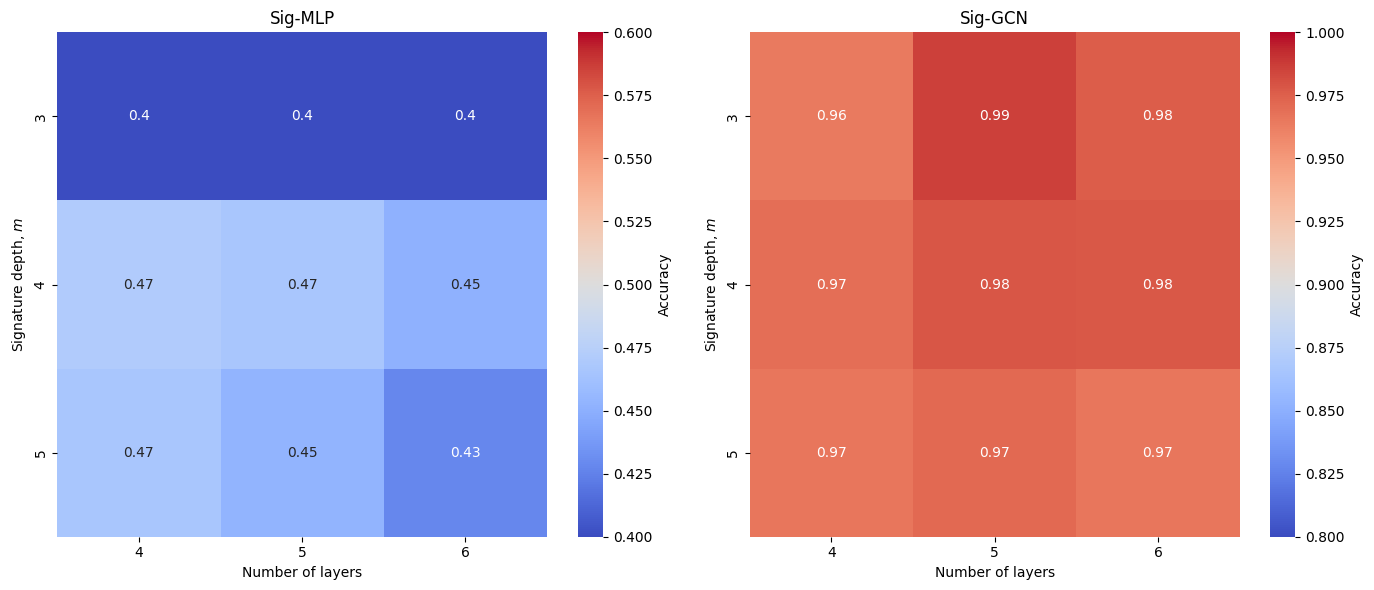

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

pivot_table_gcn = df_gcn.pivot_table(values="Accuracy", index="SigDepth", columns="NumLayers")
sns.heatmap(pivot_table_gcn, annot=True, cmap="coolwarm", cbar_kws={'label': 'Accuracy'}, ax=ax2, vmin=0.80, vmax=1.0)
ax2.set_xlabel('Number of layers')
ax2.set_ylabel('Signature depth, $m$')
ax2.set_title('Sig-GCN')

pivot_table_mlp = df_mlp.pivot_table(values="Accuracy", index="SigDepth", columns="NumLayers")
sns.heatmap(pivot_table_mlp, annot=True, cmap="coolwarm", cbar_kws={'label': 'Accuracy'}, ax=ax1, vmin=0.40, vmax=0.60)
ax1.set_xlabel('Number of layers')
ax1.set_ylabel('Signature depth, $m$')
ax1.set_title('Sig-MLP')


plt.tight_layout()

In [49]:
df_gcn['Class'] = 'GCN'
df_mlp['Class'] = 'MLP'
df = pd.concat([df_gcn, df_mlp])

df.reset_index(drop=True, inplace=True)
df.to_json('results/brownian_1d_3b_class.json')

## TS2Vec

In [79]:
import torch
from torch_geometric.data import Data
from tqdm import tqdm

encoder = torch.load('encoders/TS2Vec.pt')

dataset = []
for seq in tqdm(seq_dataset):
    ts = torch.stack([snapshot.x for snapshot in seq]).view(-1,seq.snapshot_count,1).numpy()
    x = torch.tensor(encoder.encode(ts, encoding_window='full_series'))
    new_graph = Data(x=x,edge_index=seq.edge_index,edge_weight=seq.edge_weight,y=seq.y)
    dataset.append(new_graph)

100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


Name: GCNClassification
Number of parameters: 2179
Number of layers: 2
Signature depth: 4
Splits: 5, Trials: 4, Runs: 10, Epochs: 400


100%|██████████| 200/200 [04:42<00:00,  1.41s/it]

Accuracy: 0.8283 ± 0.0604, Recall: 0.8283 ± 0.0604, Precision: 0.8283 ± 0.0604, F1: 0.8283 ± 0.0604


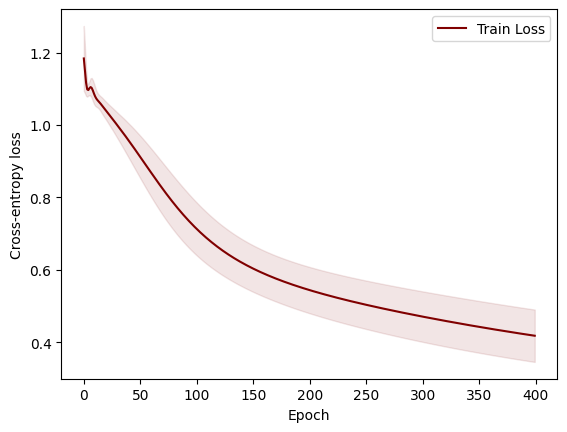

In [80]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from signatory import signature_channels
from pygsig.signature import SignatureFeatures


import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GCNClassification,MLPClassification
from pygsig.graph import  split_nodes

import importlib
importlib.reload(pygsig.models)
importlib.reload(pygsig.signature)
importlib.reload(pygsig.graph)

num_nodes = seq_dataset[0].num_nodes
dim = 1
out_channels = seq_dataset[0].y.shape[1]
num_splits = 5 # split the nodes
num_runs = len(seq_dataset)
num_trials = 4
num_epochs = 400

# hyperparameters
learning_rate = 1e-3
lasso = 0
num_hidden = 64

print_during_training = False

all_models = []
all_model_parameters = []
all_model_depths = []
all_model_layers = []
all_models_accuracy = []
all_models_recall = []
all_models_precision = []
all_models_f1 = []
all_models_confusion = []

# create models 
min_hidden_layers = 1
max_hidden_layers = 1

for num_layers in range(min_hidden_layers,max_hidden_layers+1):
    in_channels = signature_channels(2*dim,depth)
    model = GCNClassification(num_channels=[in_channels]+num_layers*[num_hidden]+[out_channels])
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Name: {model._get_name()}')
    print(f"Number of parameters: {num_params}")
    print(f"Number of layers: {num_layers+1}")
    print(f"Signature depth: {depth}")
    print(f"Splits: {num_splits}, Trials: {num_trials}, Runs: {num_runs}, Epochs: {num_epochs}")
    all_model_parameters.append(num_params)
    all_model_layers.append(num_layers+1)
    all_model_depths.append(depth)
    
    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=lasso) 
    train_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs]) 
    eval_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs])
    accuracy = np.zeros([num_splits, num_runs, num_trials])
    recall = np.zeros([num_splits, num_runs, num_trials])
    precision = np.zeros([num_splits, num_runs, num_trials])
    f1 = np.zeros([num_splits, num_runs, num_trials])
    confusion = np.zeros([num_splits, num_runs, num_trials,out_channels,out_channels])

    with tqdm(total=num_splits*num_runs*num_trials, disable=print_during_training) as pbar:
        splits = split_nodes(num_nodes, num_splits,test_ratio=1.0,seed=29)
        for split in range(num_splits):
            train_indices, eval_indices, test_indices = splits[split]
            train_mask = torch.zeros(num_nodes, dtype=torch.bool)
            eval_mask = torch.zeros(num_nodes, dtype=torch.bool)
            test_mask = torch.zeros(num_nodes, dtype=torch.bool)
            train_mask[train_indices] = True
            eval_mask[eval_indices] = True
            test_mask[test_indices] = True
            for run, data in enumerate(dataset):
                for trial in range(num_trials):
                    model.reset_parameters()
                    for epoch in range(num_epochs):
                        # train
                        model.train()
                        optimizer.zero_grad()
                        out = model(data.x, data.edge_index)
                        train_loss = criterion(out[train_mask], data.y[train_mask])
                        train_loss.backward()
                        optimizer.step()
                        # evaluate
                        model.eval()
                        with torch.no_grad():
                            eval_loss = criterion(out[eval_mask], data.y[eval_mask])
                            train_losses[split, run, trial, epoch] = train_loss.item()
                            eval_losses[split, run, trial, epoch] = eval_loss.item()
                        if epoch % 10 == 0 and print_during_training:
                            print(f'Split {split}, Run {run}, Trial {trial}, Epoch {epoch}, Train MSE Loss: {train_loss.item():.4f}, Evaulation MSE Loss: {eval_loss.item():.4f}')
                    pbar.update(1)
                    # compute the errors on the testing loss after the last epoch
                    with torch.no_grad():
                        out = model(data.x, data.edge_index)
                        accuracy[split,run,trial] = accuracy_score(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy())
                        recall[split,run,trial] = recall_score(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy(),average='micro')
                        precision[split,run,trial] = precision_score(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy(),average='micro')
                        f1[split,run,trial] = f1_score(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy(),average='micro')
                        confusion[split,run,trial] = confusion_matrix(data.y[test_mask].argmax(dim=1).numpy(), out[test_mask].argmax(dim=1).numpy())

    print(f'Accuracy: {np.mean(accuracy):.4f} ± {np.std(accuracy):.4f}, Recall: {np.mean(recall):.4f} ± {np.std(recall):.4f}, Precision: {np.mean(precision):.4f} ± {np.std(precision):.4f}, F1: {np.mean(f1):.4f} ± {np.std(f1):.4f}')
    all_models_accuracy.append(accuracy)
    all_models_recall.append(recall)
    all_models_precision.append(precision)
    all_models_f1.append(f1)
    all_models_confusion.append(confusion)

    # Plotting
    avg_train_losses = np.mean(train_losses, axis=(0,1,2))
    std_train_losses = np.std(train_losses, axis=(0,1,2))
    
    plt.figure()
    plt.plot(avg_train_losses,  label='Train Loss', color='maroon')
    plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
    plt.xlabel('Epoch')
    plt.ylabel('Cross-entropy loss')
    plt.legend()
    plt.show()

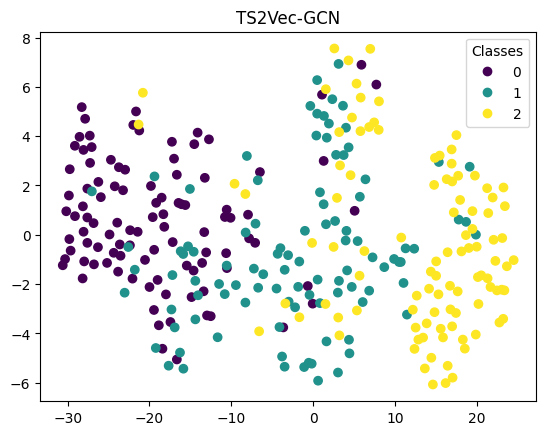

In [82]:
from sklearn.manifold import TSNE

latent_variables = model.conv[0](data.x, data.edge_index)

tsne = TSNE(n_components=2, perplexity=30, random_state=29)
X_embedded = tsne.fit_transform(latent_variables.detach().numpy())

plt.figure()
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=data.y.argmax(dim=1).numpy(), cmap='viridis')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title('TS2Vec-GCN')
plt.show()

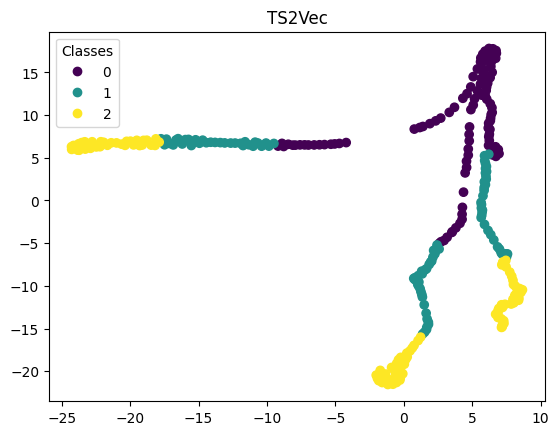

In [81]:
from sklearn.manifold import TSNE

data = dataset[np.random.randint(0,len(dataset))]

tsne = TSNE(n_components=2, perplexity=30, random_state=29)
X_embedded = tsne.fit_transform(data.x.detach().numpy())

plt.figure()
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=data.y.argmax(dim=1).numpy(), cmap='viridis')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title('TS2Vec')
plt.show()